### Imports

In [130]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
sns.set_palette("tab20")

#imports for modelling
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

random_state = 42
np.random.seed(42)

## Additional Preprocessing for Multiclass

In [131]:
df_train = pd.read_csv('Data/df_train_preprocessed.csv')
df_train.head()

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,glucose_test_performed,a1c_test_performed,rosiglitazone,pioglitazone,glipizide,metformin,repaglinide,glyburide,insulin,glimepiride
0,533253,70110,Caucasian,1,75,NaN,No provider,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,426224,29775006,AfricanAmerican,0,55,NaN,No provider,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,634063,80729253,Caucasian,1,65,NaN,No provider,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,890610,2919042,AfricanAmerican,0,65,NaN,MC,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,654194,84871971,Caucasian,1,75,NaN,HM,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
df_train['readmitted_multiclass'].value_counts()

No          38405
>30 days    24881
<30 days     7950
Name: readmitted_multiclass, dtype: int64

In [133]:
#encoding for multiclass variable
mapping = {'No': 0, '>30 days': 1, '<30 days': 2}
df_train['readmitted_multiclass'] = df_train['readmitted_multiclass'].map(mapping)

In [134]:
def frequency_encode(df, cat_column):
    encoding = df[cat_column].value_counts(normalize=True).to_dict()
    df[f'{cat_column}_encoded'] = df[cat_column].map(encoding)

    return df

### Admission_Source

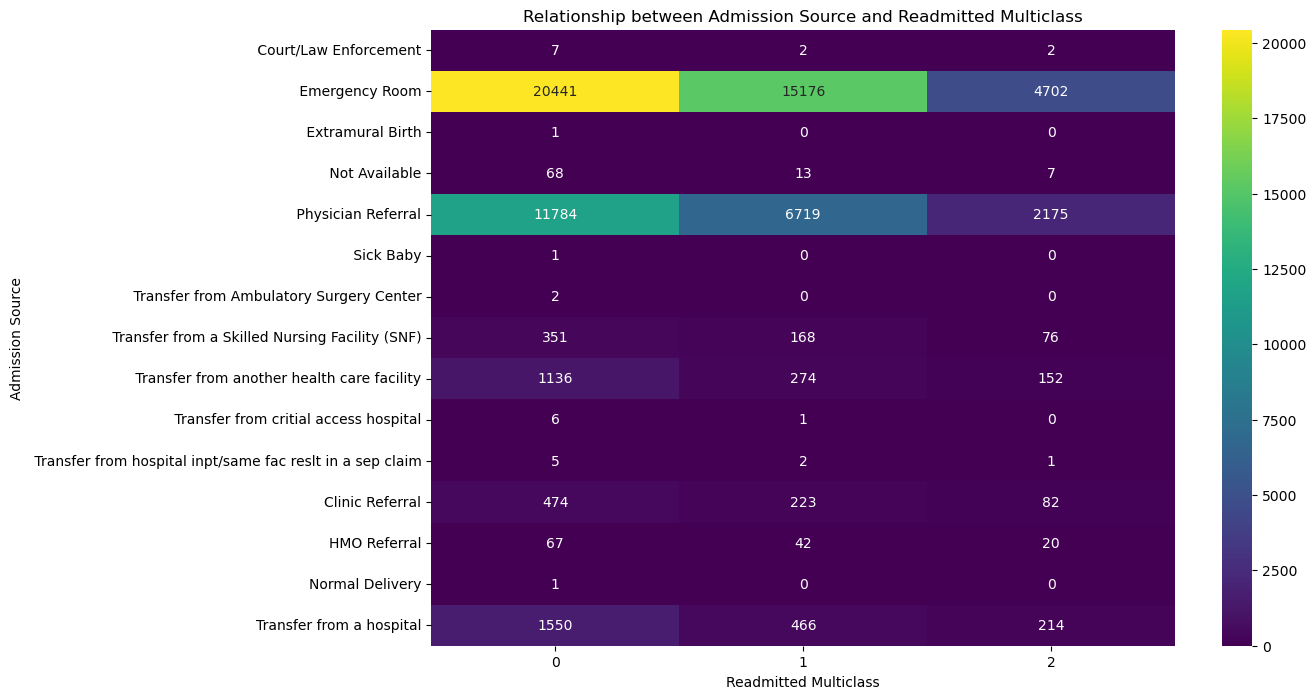

In [135]:
# Create the contingency table
crosstab_result = pd.crosstab(df_train['admission_source'], df_train['readmitted_multiclass'])

# Plot the bar plot
plt.figure(figsize=(12, 8))
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Relationship between Admission Source and Readmitted Multiclass')
plt.xlabel('Readmitted Multiclass')
plt.ylabel('Admission Source')
plt.show()


As we can see, most of the values are in emergency room and physician referral. 
Since previously we have done the pre processing based on the readmitted binary variable, we are going to perform frequency encoding.
Frequency enconding does not work with NaN values, so we will impute this column with mode.

In [136]:
most_frequent_value = df_train['admission_source'].mode()[0]
df_train['admission_source'] = df_train['admission_source'].fillna(most_frequent_value)

# Check if the imputation and removal were successful
remaining_missing_values = df_train['admission_source'].isnull().sum()
remaining_missing_values

0

In [137]:
# Applying Frequency Encoding to the 'admission_source' column
df_train = frequency_encode(df_train, 'admission_source')

#### Medical_specialty

Since previously we have done the pre processing based on the readmitted binary variable, we are going to perform probability encoding.
<br> In probability encoding, we replace each category in medical_specialty with a vector of probabilities, where each element in the vector represents the probability of each class in the target variable given that medical specialty.
<br> However, we will need to fill the missing values with 'unknown'

In [138]:
# Replacing missing values in 'medical_specialty' with a placeholder 'Unknown'
df_train['medical_specialty'].fillna('Unknown', inplace=True)

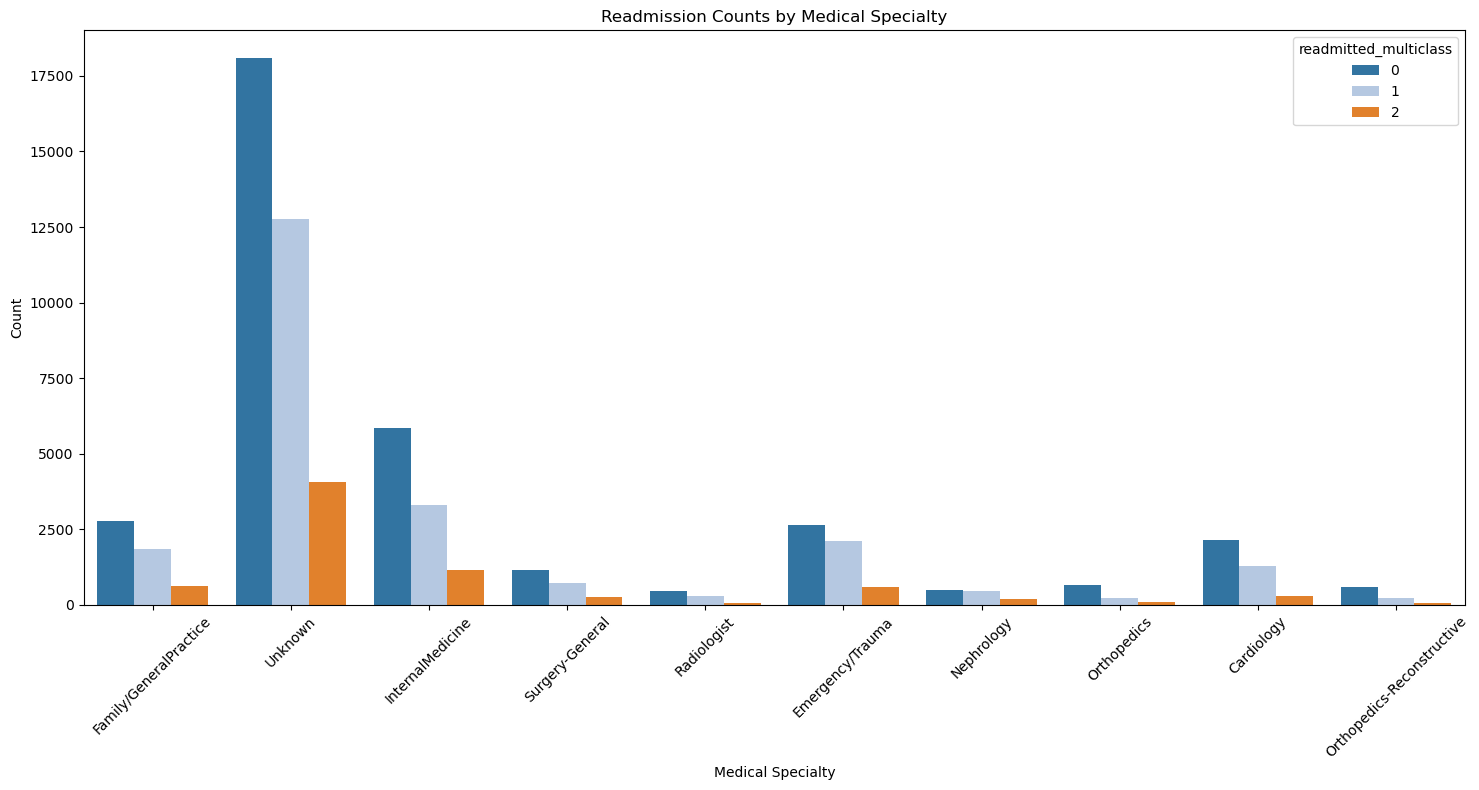

In [141]:
# Selecting the top 10 medical specialties based on frequency
top_medical_specialties_original = df_train['medical_specialty'].value_counts().head(10).index

# Filtering the DataFrame for these top medical specialties
top_specialties_data_original = df_train[df_train['medical_specialty'].isin(top_medical_specialties_original)]

# Creating count plot
plt.figure(figsize=(15, 8))
sns.countplot(data=top_specialties_data_original, x='medical_specialty', hue='readmitted_multiclass')
plt.xticks(rotation=45)
plt.title('Readmission Counts by Medical Specialty')
plt.ylabel('Count')
plt.xlabel('Medical Specialty')
plt.tight_layout()
plt.show()


In [79]:
target_classes = df_train['readmitted_multiclass'].unique()

#Calculating the probability of each target class for each category in 'medical_specialty'
medical_specialty_probs = df_train.groupby('medical_specialty')['readmitted_multiclass'].value_counts(normalize=True).unstack().fillna(0)

medical_specialty_probs.columns = [f'medical_specialty_prob_{col}' for col in medical_specialty_probs.columns]

# Merging the probability data back into the original DataFrame
df_train = df_train.merge(medical_specialty_probs, left_on='medical_specialty', right_index=True, how='left')

# Displaying the first few rows to verify the changes
df_train.head()


,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,glipizide,metformin,repaglinide,glyburide,insulin,glimepiride,admission_source_freq,medical_specialty_prob_0,medical_specialty_prob_1,medical_specialty_prob_2
0,533253,70110,Caucasian,1,75,NaN,No provider,0,0,2,...,0,0,0,0,0,0,45144,0.528273,0.354610,0.117117
1,426224,29775006,AfricanAmerican,0,55,NaN,No provider,0,0,0,...,0,0,0,0,1,0,779,0.518441,0.365701,0.115858
2,634063,80729253,Caucasian,1,65,NaN,No provider,0,0,1,...,0,0,0,0,1,1,45144,0.528273,0.354610,0.117117
3,890610,2919042,AfricanAmerican,0,65,NaN,MC,0,0,1,...,0,0,0,0,0,0,1562,0.567334,0.321123,0.111543
4,654194,84871971,Caucasian,1,75,NaN,HM,1,0,0,...,0,0,0,0,0,0,20678,0.518441,0.365701,0.115858


#### Admission_Type

kept same pre processing for this column but we are not using it

#### Discharge_disposition

Same logic as medical specialty

In [142]:
df_train['discharge_disposition'].fillna('Unknown')

0                                       Discharged to home
1        Discharged/transferred to a federal health car...
2                                       Discharged to home
3                                       Discharged to home
4        Discharged/transferred to home with home healt...
                               ...                        
71231                                   Discharged to home
71232                                              Unknown
71233                                              Unknown
71234                        Discharged/transferred to SNF
71235                                   Discharged to home
Name: discharge_disposition, Length: 71236, dtype: object

In [143]:
df_train = frequency_encode(df_train, 'discharge_disposition')

#### Medication

In [89]:
#binary identifier if there was medication or not
df_train['medication_binary'] = df_train['medication'].apply(lambda x: 0 if x == '[]' else (1 if len(str(x)) > 2 else np.nan))

In [90]:
medication_list = []
for i in df_train['medication']:
    i = i.replace('[', '').replace(']', '').replace("'", '').replace('-', ',')
    x = i.strip().split(',')
    for j in x:
        if len(j) > 0:
            medication_list.append(j.strip())
medication_list = list(set(medication_list))
medication_list

['glipizide',
 'nateglinide',
 'tolbutamide',
 'acarbose',
 'miglitol',
 'insulin',
 'repaglinide',
 'troglitazone',
 'glimepiride',
 'chlorpropamide',
 'acetohexamide',
 'pioglitazone',
 'metformin',
 'rosiglitazone',
 'tolazamide',
 'glyburide']

In [91]:
for i in medication_list:
    df_train[i] = df_train['medication'].astype(str).apply(lambda x: 1 if i in x else 0)
#get rid of rare medications columns
for i in medication_list:
    if df_train[i].sum()/len(df_train) < 0.01:
        df_train.drop(columns = [i], inplace = True)

for i in medication_list:
    try:
        cnt = df_train[['encounter_id',i]].groupby(by = i).count().sort_values(by = 'encounter_id', ascending=False)
        mean = df_train[['readmitted_binary',i]].groupby(by = i).mean().sort_values(by = 'readmitted_binary', ascending=False)
        print(pd.concat([cnt, mean], axis = 1))
    except:
        pass

           encounter_id  readmitted_binary
glipizide                                 
0                 62321           0.111616
1                  8915           0.111497
         encounter_id  readmitted_binary
insulin                                 
1               38105           0.121952
0               33131           0.099695
             encounter_id  readmitted_binary
repaglinide                                 
0                   70158           0.111192
1                    1078           0.138219
             encounter_id  readmitted_binary
glimepiride                                 
0                   67661           0.112310
1                    3575           0.098182
              encounter_id  readmitted_binary
pioglitazone                                 
0                    66143           0.111909
1                     5093           0.107599
           encounter_id  readmitted_binary
metformin                                 
0                 56805           

### Imputation of missing values

In [92]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

features_for_transform = [
    'gender', 
    'has_weight',
    'race_Asian', 'race_Caucasian', 'race_Hispanic',
    'race_Other', 'race_nan',
    
    'age', 
    'average_pulse_bpm',
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'total_visits',
    'max_visits_of_one_type',
    'length_of_stay_in_hospital',
    'number_lab_tests', 
    'non_lab_procedures', 
    'number_of_medications',
    'number_diagnoses'
]

df_train_for_transform = df_train[features_for_transform]

features_for_scaling = ['age',
                        'average_pulse_bpm',
                        'outpatient_visits_in_previous_year',
                        'emergency_visits_in_previous_year',
                        'inpatient_visits_in_previous_year',
                        'total_visits',
                        'max_visits_of_one_type',
                        'length_of_stay_in_hospital',
                        'number_lab_tests', 
                        'non_lab_procedures', 
                        'number_of_medications',
                        'number_diagnoses']

scaler = MinMaxScaler()
scaled_df_train_for_transform = scaler.fit_transform(df_train_for_transform[features_for_scaling])
scaled_df_train_for_transform = np.concatenate((df_train_for_transform[df_train_for_transform.columns.difference(features_for_scaling)],
                np.array(scaled_df_train_for_transform)), axis=1)


imputer = KNNImputer(n_neighbors=5)
imputed_data_train = pd.DataFrame(imputer.fit_transform(scaled_df_train_for_transform), columns = features_for_transform)

imputed_data_train = pd.DataFrame(np.concatenate((imputed_data_train[imputed_data_train.columns.difference(features_for_scaling)],
                scaler.inverse_transform(imputed_data_train[features_for_scaling])), axis = 1), columns = features_for_transform)



features_to_impute = ['age', 'gender', 'number_lab_tests', 'number_of_medications']
df_train[features_to_impute] = np.round(imputed_data_train[features_to_impute])

df_train

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,medical_specialty_prob_2,discharge_disposition_encoded,diabetes_severity_group_Mild,diabetes_severity_group_Moderate,diabetes_severity_group_Severe,diabetes_type_I - controlled,diabetes_type_I - uncontrolled,diabetes_type_II - controlled,diabetes_type_II - uncontrolled,medication_binary
0,533253,70110,Caucasian,1.0,75.0,NaN,No provider,0,0,2,...,0.117117,0.621713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,426224,29775006,AfricanAmerican,0.0,55.0,NaN,No provider,0,0,0,...,0.115858,0.000044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,634063,80729253,Caucasian,1.0,65.0,NaN,No provider,0,0,1,...,0.117117,0.621713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,890610,2919042,AfricanAmerican,0.0,65.0,NaN,MC,0,0,1,...,0.111543,0.621713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,654194,84871971,Caucasian,1.0,75.0,NaN,HM,1,0,0,...,0.115858,0.132491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71231,660160,24531381,AfricanAmerican,1.0,85.0,NaN,MC,0,1,0,...,0.111543,0.621713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71232,826429,4663818,AfricanAmerican,1.0,75.0,NaN,No provider,0,0,0,...,0.115858,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71233,332030,23397147,Caucasian,1.0,65.0,NaN,No provider,0,2,2,...,0.115858,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
71234,757560,52161750,Caucasian,0.0,65.0,NaN,BC,0,0,2,...,0.113179,0.143893,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


## Model and feature selection

### Set train and test data

In [94]:
df_train.columns

Index(['encounter_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year',
       ...
       'medical_specialty_prob_2', 'discharge_disposition_encoded',
       'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate',
       'diabetes_severity_group_Severe', 'diabetes_type_I - controlled',
       'diabetes_type_I - uncontrolled', 'diabetes_type_II - controlled',
       'diabetes_type_II - uncontrolled', 'medication_binary'],
      dtype='object', length=107)

In [110]:
columns_to_use = ['encounter_id', 'patient_id', 
                  
                  'gender', 'age', 'has_weight',
                  
                  'outpatient_visits_in_previous_year',
                  'emergency_visits_in_previous_year',
                  'inpatient_visits_in_previous_year', 
                  'total_visits', 'max_visits_of_one_type',
                  
                  'average_pulse_bpm', 
                  'length_of_stay_in_hospital', 

                  'medical_specialty_prob_0','medical_specialty_prob_1',
                   'medical_specialty_prob_2',
                  
                  'number_lab_tests',
                  'non_lab_procedures', 
                  'number_of_medications', 
                  'number_diagnoses',
                  
                  'glucose_test_performed', 
        
                  'change_in_meds_during_hospitalization', 
                  'prescribed_diabetes_meds', 

                  'admission_source_freq',
                  
                  'race_Asian', 'race_Caucasian', 'race_Hispanic',
                  'race_Other', 'race_nan', 
                  
                  'payer_code_No provider',
                  'payer_code_Other provider',        
                   
                  'diabetes_severity_group_Mild', 'diabetes_severity_group_Moderate', 'diabetes_severity_group_Severe',
                  
                  'diabetes_type_I - controlled', 'diabetes_type_I - uncontrolled',
                  'diabetes_type_II - controlled', 'diabetes_type_II - uncontrolled',
                  
                  'glimepiride', 'pioglitazone', 'repaglinide', 'metformin', 'glyburide',
                  'rosiglitazone', 'glipizide', 'insulin']
                 

In [111]:
data = df_train[columns_to_use]
target = df_train['readmitted_multiclass']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [112]:
df_train['discharge_disposition_encoded']

0        0.621713
1        0.000044
2        0.621713
3        0.621713
4        0.132491
           ...   
71231    0.621713
71232         NaN
71233         NaN
71234    0.143893
71235    0.621713
Name: discharge_disposition_encoded, Length: 71236, dtype: float64

### Imports for modelling

In [113]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from tqdm import tqdm
import random
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

random_state = 42
np.random.seed(42)

In [114]:
def target_encoder(fit_data, transform_data, target, features_for_encoding, smoothing=100):
    target_encoder = ce.TargetEncoder(cols=features_for_encoding, smoothing=smoothing)  
    target_encoder.fit(fit_data[features_for_encoding], fit_data[target].astype(int))
    encoded_df = target_encoder.transform(transform_data[features_for_encoding])
    features_for_encoding_pass = [i + '_target' for i in features_for_encoding]
    encoded_df =  pd.concat((transform_data[transform_data.columns.difference(features_for_encoding)],
                        pd.DataFrame(np.array(encoded_df), columns = features_for_encoding_pass)), axis=1)
    return encoded_df, features_for_encoding_pass

In [115]:
def scaler(fit_data, transform_data, features_for_scaling, scaling_type = 'minmax'):
    if scaling_type == 'minmax':
        sc = MinMaxScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1) 
        return scaled_df
    if scaling_type == 'standard':
        sc = StandardScaler()
        sc.fit(fit_data[features_for_scaling])
        scaled_df = sc.transform(transform_data[features_for_scaling])
        scaled_df = pd.concat((transform_data[transform_data.columns.difference(features_for_scaling)],
                        pd.DataFrame(scaled_df, columns = features_for_scaling)), axis=1)
        return scaled_df

In [116]:
def patient_features(df_train, df_test, multiclass = False):
    df_all = pd.concat([df_train, df_test])

    list_for_scaling = []
    
    # total visits of one patient in dataset, excluding current visit
    patient_total_visits = df_train[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_train = pd.merge(df_train, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    patient_total_visits = df_all[['patient_id', 'encounter_id']].groupby('patient_id').count().rename(columns={'encounter_id': 'patient_total_visits'}).reset_index()
    patient_total_visits['patient_total_visits'] = (patient_total_visits['patient_total_visits'] - 1).astype('int')
    df_test = pd.merge(df_test, patient_total_visits, how = 'left', on = 'patient_id').fillna(0)

    list_for_scaling.append('patient_total_visits')

    if multiclass == False:
        # check if we know that this person was readmitted on any other visit we know and calculate number of readmissions
        was_readmitted_encounter = df_train[['patient_id', 
                                   'encounter_id',
                                   'readmitted_binary']].groupby(['patient_id','encounter_id']).max(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_encounter'}).reset_index()
        was_readmitted_patient = df_train[['patient_id', 
                                       'readmitted_binary']].groupby(['patient_id']).sum(numeric_only=True).rename(columns={'readmitted_binary': 'was_readmitted_patient'}).reset_index()
        was_readmitted = pd.merge(was_readmitted_encounter, was_readmitted_patient, on = 'patient_id')
        was_readmitted['patient_num_readmitted'] = (was_readmitted['was_readmitted_patient'] - was_readmitted['was_readmitted_encounter']).astype('int')
        was_readmitted['patient_was_readmitted'] = was_readmitted['patient_num_readmitted'].apply(lambda x: 1 if x > 0 else 0).astype('category')
        df_train = pd.merge(df_train, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
    
        df_test = pd.merge(df_test, was_readmitted[['patient_num_readmitted', 'patient_was_readmitted', 'encounter_id']], how = 'left', on = 'encounter_id').fillna(0)
        df_test[['patient_num_readmitted', 'patient_was_readmitted']] = df_test[['patient_num_readmitted', 'patient_was_readmitted']].astype(int)
        list_for_scaling.append('patient_num_readmitted')

    return df_train, df_test, list_for_scaling

In [117]:
def upsampler(data, 
              target,  
              upsample_type = 'simple', 
              upsample_size = 1):
    majority_class_label = data[target].value_counts().idxmax()
    minority_class_labels = data[target].value_counts().index.drop(majority_class_label)
    balanced_data = pd.DataFrame()
    if upsample_type == 'simple':
        for label in minority_class_labels:
            if len(data[data[target] == majority_class_label])*upsample_size > len(data[data[target] == label]):
                minority_upsampled = resample(data[data[target] == label], replace=True, n_samples=int(len(data[data[target] == majority_class_label])*upsample_size), 
                                                  random_state = random_state)
                balanced_data = pd.concat([balanced_data, minority_upsampled])
            else:
                balanced_data = pd.concat([balanced_data, data[data[target] == label]])
        balanced_data = pd.concat([balanced_data, data[data[target] == majority_class_label]])
    if upsample_type == 'SMOTE':
        X = data.drop(columns = target)
        categorical_features = X.select_dtypes(include='category').columns
        cat_ind = [X.columns.get_loc(col) for col in categorical_features]
        smote_nc = SMOTENC(categorical_features=cat_ind, random_state=random_state)
        X_resampled, y_resampled = smote_nc.fit_resample(X, data[target])  
        balanced_data = pd.concat([X_resampled, y_resampled], axis = 1)
    return balanced_data

In [118]:
def cross_validation(data, 
                     target, 
                     model, 
                     params, 
                     multiclass = True,
                     
                     scaling = False,
                     features_for_scaling_minmax = [],
                     features_for_scaling_standard = [],

                     target_encoding = False,
                     features_for_encoding = [],
                     smoothing = 100,
                     
                     upsample = False, 
                     upsample_size = 1,
                     upsample_type = 'simple', 
                     cv=5
                     ):
    # Defining some lists to collect data
    feature_imp = []
    f1 = []
    confusion_matrix_list = []
    precision_score_list = []
    recall_score_list = []
    roc_auc_score_list = []

    # A bit of resampling just to mix data
    data = data.sample(frac=1, random_state=random_state)
    data[target] = data[target].astype(int)

    # create stratified folds
    skf = StratifiedKFold(n_splits=cv, shuffle = True, random_state = random_state)
    split = list(skf.split(data.drop(columns = target), data[target]))
    all_train_index = [i[0] for i in split]
    all_val_index = [i[1] for i in split]
    
    for i in range(cv):
        val_index = all_val_index[i]
        train_index = all_train_index[i]
        train_data, val_data = data.loc[train_index], data.loc[val_index]


        #Target encoding
        if target_encoding == True:
                val_data, _ = target_encoder(train_data, val_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                train_data, features_for_encoding_pass = target_encoder(train_data, train_data, features_for_encoding = features_for_encoding, target = target, smoothing = smoothing)
                features_for_scaling_minmax_full = features_for_scaling_minmax + list(features_for_encoding_pass)
        else:
            features_for_scaling_minmax_full = features_for_scaling_minmax

        #creating features on patient level that we will use
        train_data, val_data, pat_features_scale = patient_features(train_data, val_data, multiclass = multiclass)
        features_for_scaling_minmax_full = features_for_scaling_minmax_full + pat_features_scale

            
        # Scaling features
        if scaling == True:
            if len(features_for_scaling_minmax) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
                train_data = scaler(train_data, train_data, features_for_scaling_minmax_full, scaling_type = 'minmax')
            if len(features_for_scaling_standard) > 0:
                val_data = scaler(train_data, val_data, features_for_scaling_standard, scaling_type = 'standard')
                train_data = scaler(train_data, train_data, features_for_scaling_standard, scaling_type = 'standard')
                
        # Upsampling only train data 
        if upsample == True:
            train_data = upsampler(train_data, target, upsample_type = upsample_type,  upsample_size = upsample_size)

        # Defining train and val datasets
        X_train = train_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_train = train_data[target]
        
        X_val = val_data.drop(target, axis=1).drop(columns = ['encounter_id', 'patient_id'])
        y_val = val_data[target]

        # Fit and predict
        model.set_params(**params)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        #Feature importances if our model can do this
        try:
            try:
                feature_imp.append(model.feature_importances_)
            except:
                pass
            try:
                feature_imp.append(model.coef_)
            except:
                pass
        except:
            pass

        # Calculating f1 scores and other metrics
        if multiclass == False:
            f1.append([f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val)])
            recall_score_list.append([recall_score(y_train, y_pred_train), recall_score(y_val, y_pred_val)])
            precision_score_list.append([precision_score(y_train, y_pred_train), precision_score(y_val, y_pred_val)])
            roc_auc_score_list.append([roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)])
        if multiclass == True:
            f1.append([f1_score( y_train, y_pred_train, average = 'micro'), f1_score(y_val, y_pred_val, average = 'micro')])
            recall_score_list.append([recall_score( y_train, y_pred_train, average = 'micro'), recall_score(y_val, y_pred_val, average = 'micro')])
            precision_score_list.append([precision_score(y_train, y_pred_train, average = 'micro'), precision_score(y_val, y_pred_val, average = 'micro')])
            # roc_auc_score_list.append([roc_auc_score( y_train, y_pred_train.reshape(-1, 1), multi_class='ovr', average = 'micro'), roc_auc_score(y_val, y_pred_val.reshape(-1, 1), multi_class='ovr', average = 'micro')])

        
        confusion_matrix_list.append([confusion_matrix(y_train, y_pred_train), confusion_matrix(y_val, y_pred_val)])

    # Printing results
    print(model)
    print('F1 train: {:.3f}, F1_val: {:.3f}'.format(np.array(f1).mean(axis = 0)[0],
                                                   np.array(f1).mean(axis = 0)[1]))
    return [model.get_params(), 
            {'f1' : np.array(f1).mean(axis = 0), 
             'recall_score' : np.array(recall_score_list).mean(axis = 0),
             'precision_score' : np.array(precision_score_list).mean(axis = 0),
             'roc_auc_score' : np.array(roc_auc_score_list).mean(axis = 0)
            }, 
            {'f1' : f1, 
             'recall_score' : recall_score_list,
             'precision_score' : precision_score_list,
             'roc_auc_score' : roc_auc_score_list,
             'confusion_matrix': confusion_matrix_list
            },
            X_train.columns, 
            np.mean(np.array(feature_imp), axis = 0),
            ]

### Important functions

### Model selection

In [119]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [120]:
features_for_scaling_minmax = ['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'total_visits',
       'max_visits_of_one_type', 'average_pulse_bpm','length_of_stay_in_hospital',
       'non_lab_procedures', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result']
features_for_scaling_standard = ['number_lab_tests', 'number_of_medications', 'admission_type_freq']

data = pd.concat([X_train, y_train], axis = 1)

target = 'readmitted_multiclass'

In [145]:
#not working, have to figure out why 

for var in X_train:
    TestIndependence(X_train[columns_to_use],y_train, columns_to_use)

ValueError: Data must be 1-dimensional

**Random Forest**

In [121]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=16, min_samples_leaf=10,
                       min_samples_split=5, n_estimators=156)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = rf_classifier.predict(X_test)

# Calculate the F1 score
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')


feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)
print(f1_rf)

patient_id                               0.111398
encounter_id                             0.076688
inpatient_visits_in_previous_year        0.072996
number_lab_tests                         0.063356
max_visits_of_one_type                   0.061774
total_visits                             0.060833
average_pulse_bpm                        0.059431
number_of_medications                    0.055897
age                                      0.042262
length_of_stay_in_hospital               0.039338
number_diagnoses                         0.035747
medical_specialty_prob_1                 0.029150
non_lab_procedures                       0.027650
medical_specialty_prob_0                 0.027560
medical_specialty_prob_2                 0.025976
admission_source_freq                    0.022593
emergency_visits_in_previous_year        0.016259
outpatient_visits_in_previous_year       0.014416
payer_code_No provider                   0.014320
gender                                   0.013016


**Logistic Regression**

In [122]:
lr_classifier = LogisticRegression(max_iter=900)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_classifier.predict(X_test)

# Calculate accuracy as an example metric
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f1_lr)

0.378453302631329


**MLP CLassifier**

In [123]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create and train a Multi-layer Perceptron (MLP) classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred_mlp = mlp_classifier.predict(X_test)

f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

print(f1_mlp)


0.09161890475079396


**Decision Trees**

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)

f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print(f1_dt)

0.48204908020831827


In [125]:
nan_counts_per_column = df_train.isna().sum()

# Print the counts of NaN values per column
print(nan_counts_per_column)

encounter_id                          0
patient_id                            0
race                               5070
gender                                0
age                                   0
                                   ... 
diabetes_type_I - controlled          0
diabetes_type_I - uncontrolled        0
diabetes_type_II - controlled         0
diabetes_type_II - uncontrolled       0
medication_binary                     0
Length: 107, dtype: int64
